In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint
import pandas as pd

In [101]:
df = pd.read_csv("../FittingExperiments/Data/Grim/data.csv")
df['timestamp (ms)'] = pd.to_timedelta(df['timestamp (ms)'], unit='ms')
df.set_index('timestamp (ms)', inplace=True)

def rrc3_pressure_conversion_function_ft(press_kpa):
    pressure = press_kpa * 10
    altitude = (1 - pow(pressure / 1_013.25, 0.190284)) * 145_366.45
    return altitude


def ft_to_meters(ft): return ft * 0.3048
boost_end = 3_500
first_charge = 28_125
altim = df[['pressure (kPa)']].copy()
altim['alt_m_asl'] = altim['pressure (kPa)'].map(rrc3_pressure_conversion_function_ft).map(ft_to_meters)
altim['alt_m_agl'] = altim['alt_m_asl'] - altim['alt_m_asl'].min()

In [95]:
def f(y, t, paras):
    """
    Your system of differential equations
    """

    x1 = y[0]
    x2 = y[1]

    try:
        G = paras['g'].value
        mb = paras['mb'].value

    except KeyError:
        G, mb = paras
    # the model equations
    f0 = G 
    f1 = -mb * x2
    return [f0, f1]


In [86]:
def g(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(paras,))
    return x


def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value
    model = g(t, x0, paras)

    # you only have data for one of your variables
    x2_model = model[:, 1]
    return (x2_model - data).ravel()




In [72]:
rs_df = df.loc[pd.Timedelta(boost_end, unit='ms'):pd.Timedelta(first_charge, unit='ms')].resample('500ms').mean().dropna()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 50
    # variables        = 3
    chi-square         = 243.890067
    reduced chi-square = 5.18915036
    Akaike info crit   = 85.2347286
    Bayesian info crit = 90.9707977
##  Warning: uncertainties could not be estimated:
[[Variables]]
    x10:  81.85196 (fixed)
    x20:  76.2777657 (init = 0)
    g:    0.00000000 (init = 0)
    mb:   1.7474e-05 (init = 0)


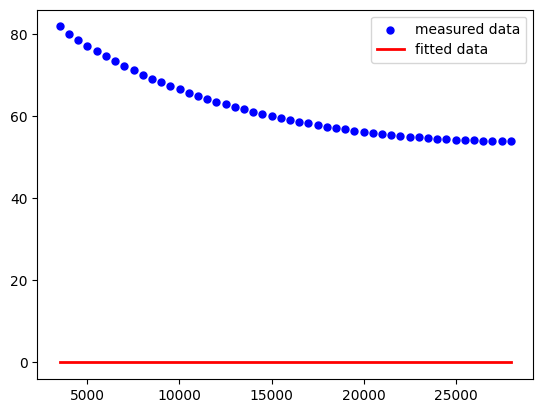

In [100]:
# initial conditions
x10 = rs_df['pressure (kPa)'].iloc[0]
x20 = 0
y0 = [x10, x20]

# measured data
t_measured = rs_df.index.astype(int).map(lambda x : x / 1_000_000).to_numpy()
x2_measured = rs_df['pressure (kPa)'].to_numpy()

plt.figure()
plt.scatter(t_measured, x2_measured, marker='o', color='b', label='measured data', s=25)

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=True)

params.add('g', value=0.0) #, min=0.0001, max=2.
params.add('mb', value=0.0) #, min=0.0001, max=2.

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
data_fitted = g(t_measured, y0, result.params)

# plot fitted data
plt.plot(t_measured, data_fitted[:, 1], '-', linewidth=2, color='red', label='fitted data')
plt.legend()
# plt.xlim([0, max(t_measured)])
# plt.ylim([0, 1.1 * max(data_fitted[:, 1])])
# display fitted statistics
report_fit(result)

plt.show()